### installing libraries

In [2]:
!pip install geopandas


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.6/323.6 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 79.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 115.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 81.8 MB/s eta 0:00:00


In [3]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import requests
import os

from io import StringIO


import zipfile
import geopandas as gpd

import gzip
import shutil

from shapely.geometry import Point
import geopandas as gpd

from sklearn.neighbors import KDTree
import ast

import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split
from collections import Counter

## defining data sources

To reduce resource exhaustion, some transformations are performed on datasets immediately after they are loaded, before they are merged. This helps reduce the dimensionality of the data.

### function for accessing csv's through http requests

In [4]:
#returns csv as string
def fetch_csv_from_http(url):
    response = requests.get(url)
    if response.status_code == 200:
        csv_data = StringIO(response.text)
    else:
        return "fetch failed"
    return csv_data

### downloading the points of interest dataset

In [5]:
poi_url = "https://download.geofabrik.de/europe/austria-latest-free.shp.zip"
response = requests.get(poi_url)
with open("austria-latest-free.shp.zip", "wb") as file:
    file.write(response.content)

with zipfile.ZipFile("austria-latest-free.shp.zip", "r") as zip_ref:
    zip_ref.extractall("austria_shapefiles")

In [6]:
pois = gpd.read_file("austria_shapefiles/gis_osm_pois_free_1.shp")
print(pois.head())

     osm_id  code        fclass           name                   geometry
0  15079895  2006     telephone           None  POINT (16.28689 48.19691)
1  15079903  2501   supermarket       Eurospar  POINT (16.28767 48.19697)
2  15080180  2501   supermarket     Billa Plus  POINT (16.29891 48.19776)
3  15080251  2522   sports_shop  Sports Direct  POINT (16.28276 48.19288)
4  17310328  2701  tourist_info           None  POINT (13.49914 47.59028)


In [7]:
num_classes = pois["fclass"].nunique()
print(f"Number of different classes in a column 'fclass': {num_classes}")

Number of different classes in a column 'fclass': 139


As we are going to merge datasets and encode categorical variables, 139 different classes can lead to significantly high dimensions, that is why we will categorize them before merging and overall preprocessing and highlite most important classes from our opinion

In [8]:
poi_category_map = {
    'bakery': 'cafe_restaurant', 'restaurant': 'cafe_restaurant', 'cafe': 'cafe_restaurant',
    'fast_food': 'cafe_restaurant', 'bar': 'other', 'supermarket': 'supermarket',
    'vending_machine': 'other', 'beverages': 'other', 'food_court': 'cafe_restaurant',
    'pub': 'other',

    'doctors': 'other', 'dentist': 'other', 'clinic': 'other',
    'hospital': 'other', 'pharmacy': 'other', 'veterinary': 'other',
    'beauty_shop': 'other', 'hairdresser': 'other', 'optician': 'other',
    'laundry': 'other',

    'toy_shop': 'shops_and_retail', 'furniture_shop': 'other', 'clothes': 'shops_and_retail',
    'jeweller': 'shops_and_retail',
    'bookshop': 'shops_and_retail', 'gift_shop': 'shops_and_retail', 'stationery': 'other',
    'mobile_phone_shop': 'other', 'sports_shop': 'other', 'shoe_shop': 'shops_and_retail',
    'computer_shop': 'other', 'greengrocer': 'other', 'car_dealership': 'other',
    'department_store': 'other', 'outdoor_shop': 'other', 'car_wash': 'other',
    'car_rental': 'other', 'kiosk': 'other', 'bicycle_rental': 'other',

    'tourist_info': 'entertainment_leisure', 'artwork': 'entertainment_leisure', 'museum': 'entertainment_leisure',
    'theatre': 'entertainment_leisure', 'cinema': 'other', 'nightclub': 'other',
    'attraction': 'entertainment_leisure', 'sports_centre': 'other', 'park': 'park',
    'playground': 'other', 'community_centre': 'other', 'arts_centre': 'other',
    'library': 'other',
    'picnic_site': 'other', 'garden_centre': 'other', 'vending_parking': 'other',

    'waste_basket': 'other', 'camera_surveillance': 'other', 'police': 'other',
    'fire_station': 'other', 'toilet': 'other', 'public_building': 'other',
    'post_box': 'other', 'recycling': 'other', 'recycling_glass': 'other',
    'recycling_paper': 'other', 'recycling_metal': 'other', 'recycling_clothes': 'other',
    'recycling': 'other', 'post_office': 'other', 'town_hall': 'other',
    'shelter': 'other', 'ambulance': 'other', 'court': 'other',
    'prison': 'other',

    'school': 'education', 'kindergarten': 'education', 'university': 'education',
    'college': 'education', 'embassy': 'education',

    'atm': 'transport_and_infrastructure', 'telephone': 'other', 'bank': 'transport_and_infrastructure',
    'car_sharing': 'other', 'car_wash': 'other', 'vending_cigarette': 'other',
    'vending_any': 'other',

    'memorial': 'entertainment_leisure', 'bench': 'other',
    'post_box': 'other', 'wayside_cross': 'other', 'vending_cigarette': 'other',
    'vending_parking': 'other', 'stationery': 'other', 'car_wash': 'other',
}


In [9]:
pois['category'] = pois['fclass'].map(poi_category_map).fillna('other')

In [10]:
num_classes = pois["category"].nunique()
print(f"Number of different classes in a column 'fclass': {num_classes}")

Number of different classes in a column 'fclass': 8


### wienlinien datasets

In [11]:
haltestellen_url = "https://www.wienerlinien.at/ogd_realtime/doku/ogd/wienerlinien-ogd-haltestellen.csv"
haltestellen_data = fetch_csv_from_http(haltestellen_url)
haltestellen_df = pd.read_csv(haltestellen_data, sep=';')

In [12]:
haltestellen_df.head()

,DIVA,PlatformText,Municipality,MunicipalityID,Longitude,Latitude
0,60200001,Schrankenberggasse,Wien,49000001,48.173801,16.389807
1,60200002,Achengasse,Wien,49000001,48.284460,16.448925
2,60200003,Ada-Christen-Gasse,Wien,49000001,48.152830,16.386043
3,60200004,Adam-Betz-Gasse,Wien,49000001,48.215581,16.535469
4,60200005,Adamovichgasse,Wien,49000001,48.142664,16.338621


### airbnb datasets

#### download and extract gz compressed dataset

In [13]:
def download_and_extract_csv_gz(url, compressed_file, extracted_file, folder_name):
    # Create the folder if it doesn't exist
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)

    try:
        # Step 1: Download the compressed file
        response = requests.get(url, stream=True)
        if response.status_code == 200:
            with open(compressed_file, "wb") as f:
                shutil.copyfileobj(response.raw, f)
            print(f"Downloaded: {compressed_file}")
        else:
            print(f"Failed to download the file. Status code: {response.status_code}")
            return None

        # Step 2: Detect file type and extract
        if zipfile.is_zipfile(compressed_file):
            print("Detected a ZIP file. Extracting...")
            with zipfile.ZipFile(compressed_file, 'r') as zip_ref:
                zip_ref.extractall(folder_name)  # Extract all files into the specified folder
                extracted_file = os.path.join(folder_name, zip_ref.namelist()[0])  # Path of the first extracted file
                print(f"Extracted to: {folder_name}")
        else:
            print("Detected a GZIP file. Extracting...")
            extracted_file = os.path.join(folder_name, extracted_file)
            with gzip.open(compressed_file, "rb") as f_in:
                with open(extracted_file, "wb") as f_out:
                    shutil.copyfileobj(f_in, f_out)
            print(f"Extracted to: {extracted_file}")

        # Step 3: Load the CSV into a pandas DataFrame
        data = pd.read_csv(extracted_file)
        print("CSV loaded successfully.")
        return data

    except Exception as e:
        print(f"An error occurred: {e}")
        return None

    finally:
        # Cleanup: Remove the compressed file to save space
        if os.path.exists(compressed_file):
            os.remove(compressed_file)

In [14]:
airbnb_listings_url = "https://data.insideairbnb.com/austria/vienna/vienna/2024-09-11/data/listings.csv.gz"
airbnb_calendar_url = "https://data.insideairbnb.com/austria/vienna/vienna/2024-09-11/data/calendar.csv.gz"
airbnb_neighbourhoods_url = "https://data.insideairbnb.com/austria/vienna/vienna/2024-09-11/visualisations/neighbourhoods.csv"

### airbnb listing dataset

In [15]:
airbnb_listings_df = download_and_extract_csv_gz(airbnb_listings_url, "listings.csv.gz", "listings.csv", "airbnb")
airbnb_listings_df.head(30)

Downloaded: listings.csv.gz
Detected a GZIP file. Extracting...
Extracted to: airbnb/listings.csv
CSV loaded successfully.


,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,38768,https://www.airbnb.com/rooms/38768,20240911015603,2024-09-11,city scrape,central cityapartement- wifi- nice neighbourhood,39m² apartment with beautiful courtyard of the...,the Karmeliterviertel became very popular in t...,https://a0.muscache.com/pictures/ad4089a3-5355...,166283,...,4.94,4.77,4.69,NaN,t,3,3,0,0,2.38
1,40625,https://www.airbnb.com/rooms/40625,20240911015603,2024-09-11,city scrape,"Near Palace Schönbrunn, Apt. 1",Welcome to my Apt. 1!<br /><br />This is a 2be...,The neighbourhood offers plenty of restaurants...,https://a0.muscache.com/pictures/11509144/d55c...,175131,...,4.94,4.61,4.72,NaN,t,14,13,1,0,1.26
2,51287,https://www.airbnb.com/rooms/51287,20240911015603,2024-09-11,city scrape,little studio- next to citycenter- wifi- nice ...,small studio in new renovated old house and ve...,The neighbourhood has a lot of very nice littl...,https://a0.muscache.com/pictures/25163038/1c4e...,166283,...,4.95,4.87,4.59,NaN,t,3,3,0,0,2.29
3,70637,https://www.airbnb.com/rooms/70637,20240911015603,2024-09-11,city scrape,Flat in the Center with Terrace,NaN,NaN,https://a0.muscache.com/pictures/925691/c8c1bd...,358842,...,4.76,4.81,4.72,NaN,f,3,1,2,0,0.71
4,78416,https://www.airbnb.com/rooms/78416,20240911015603,2024-09-11,city scrape,Nice Apartment in Vienna center,"Newly renovated modern, comfortable apartment ...",Stadthalle – Viennas largest event center is j...,https://a0.muscache.com/pictures/7b8ed252-4016...,421075,...,4.43,4.41,4.47,NaN,t,2,2,0,0,1.09
5,90247,https://www.airbnb.com/rooms/90247,20240911015603,2024-09-11,city scrape,Beautiful New Central Apartment,"2-room apartment /55 m2 on 1st floor, fully re...",NaN,https://a0.muscache.com/pictures/miso/Hosting-...,489611,...,4.87,4.82,4.81,NaN,t,2,0,2,0,4.74
6,109679,https://www.airbnb.com/rooms/109679,20240911015603,2024-09-11,city scrape,Near Palace Schönbrunn - Apt. 4,Studio apartment for 4 persons:<br />- Bunk be...,The neighbourhood offers plenty of restaurants...,https://a0.muscache.com/pictures/1982234/1fc34...,175131,...,4.91,4.64,4.81,NaN,t,14,13,1,0,0.94
7,114505,https://www.airbnb.com/rooms/114505,20240911015603,2024-09-11,city scrape,"Near Palace Schönbrunn, Apt. 5",Studio apartment for 4 persons:<br />- Bunk be...,The neighbourhood offers plenty of restaurants...,https://a0.muscache.com/pictures/11536257/9065...,175131,...,4.96,4.71,4.80,NaN,f,14,13,1,0,0.77
8,121026,https://www.airbnb.com/rooms/121026,20240911015603,2024-09-11,city scrape,"Feels-Like-Home Apt with garage, balcony & aircon","Air-Conditioned! Comfortable, modern and styli...","Prater Park - one step away, Metro stations ""N...",https://a0.muscache.com/pictures/miso/Hosting-...,608240,...,4.98,4.82,4.88,NaN,f,2,2,0,0,2.66
9,729796,https://www.airbnb.com/rooms/729796,20240911015603,2024-09-11,previous scrape,Modern with 12qm balcony near Danube,Wifi code: On the door,"Hofer, Spar, bipa",https://a0.muscache.com/pictures/e1bf8d31-5319...,3793751,...,4.38,4.75,4.88,NaN,f,2,2,0,0,0.09


In [16]:
num_classes = airbnb_listings_df["amenities"].nunique()
print(f"Number of different amenities in a column 'amenities': {num_classes}")

Number of different amenities in a column 'amenities': 12765


Check for most popular amenties

In [17]:
airbnb_listings_df.loc[:, 'amenities'] = airbnb_listings_df['amenities'].apply(ast.literal_eval)

# Calculate the frequency of amenities in the training data
all_amenities = [amenity for amenities_list in airbnb_listings_df['amenities'] for amenity in amenities_list]
amenity_counts = Counter(all_amenities)

# We list the 4 most popular amenities
most_common_amenities = [amenity for amenity, count in amenity_counts.most_common(4)]
print(most_common_amenities)

# leave only top 4

def filter_amenities(amenities):
    return [amenity for amenity in amenities if amenity in most_common_amenities]

airbnb_listings_df.loc[:, 'amenities'] = airbnb_listings_df['amenities'].apply(filter_amenities)
airbnb_listings_df.loc[:,'amenities'] = airbnb_listings_df['amenities'].apply(lambda x: ', '.join(x))

['Kitchen', 'Wifi', 'Essentials', 'Hair dryer']


### airbnb calender dataset

In [18]:
airbnb_calendar_df = download_and_extract_csv_gz(airbnb_calendar_url, "calendar.csv.gz", "calendar.csv", "airbnb")
airbnb_calendar_df.head(20)

Downloaded: calendar.csv.gz
Detected a GZIP file. Extracting...
Extracted to: airbnb/calendar.csv
CSV loaded successfully.


,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,275668,2024-09-11,f,$59.00,NaN,2,1125
1,275668,2024-09-12,f,$59.00,NaN,2,1125
2,275668,2024-09-13,f,$59.00,NaN,2,1125
3,275668,2024-09-14,f,$59.00,NaN,2,1125
4,275668,2024-09-15,f,$59.00,NaN,2,1125
5,275668,2024-09-16,f,$59.00,NaN,2,1125
6,275668,2024-09-17,f,$59.00,NaN,2,1125
7,275668,2024-09-18,f,$59.00,NaN,2,1125
8,275668,2024-09-19,f,$59.00,NaN,2,1125
9,275668,2024-09-20,f,$59.00,NaN,2,1125


### aggregated data from day to week

In [19]:
airbnb_calendar_df['date'] = pd.to_datetime(airbnb_calendar_df['date'])

airbnb_calendar_df['price'] = airbnb_calendar_df['price'].str.replace('[\$,]', '', regex=True).astype(float)

airbnb_calendar_df['date'] = airbnb_calendar_df['date'].dt.to_period('W')
airbnb_calendar_df = airbnb_calendar_df.groupby(['listing_id', 'date']).agg({
    'price': 'mean',           # Average price for the listing on this date
    'available': lambda x: 1 if (x == 't').any() else 0,  # 1 if available for any night, 0 if not
    'minimum_nights': 'max',   # Maximum minimum_nights (to capture stricter policies)
    'maximum_nights': 'min'    # Minimum maximum_nights (to capture stricter policies)
}).reset_index()

airbnb_calendar_df = airbnb_calendar_df[airbnb_calendar_df['available'] == 0]

In [20]:
airbnb_calendar_df.head(10)

,listing_id,date,price,available,minimum_nights,maximum_nights
0,38768,2024-09-09/2024-09-15,65.0,0,30,1125
1,38768,2024-09-16/2024-09-22,65.0,0,30,1125
2,38768,2024-09-23/2024-09-29,65.0,0,30,1125
3,38768,2024-09-30/2024-10-06,65.0,0,30,1125
26,38768,2025-03-10/2025-03-16,65.0,0,30,1125
27,38768,2025-03-17/2025-03-23,65.0,0,30,1125
28,38768,2025-03-24/2025-03-30,65.0,0,30,1125
29,38768,2025-03-31/2025-04-06,65.0,0,30,1125
30,38768,2025-04-07/2025-04-13,65.0,0,30,1125
31,38768,2025-04-14/2025-04-20,65.0,0,30,1125


### airbnb neighbours data

In [21]:
airbnb_neighbourhoods_data = fetch_csv_from_http(airbnb_neighbourhoods_url)
airbnb_neighbourhoods_df = pd.read_csv(airbnb_neighbourhoods_data)
airbnb_neighbourhoods_df.head()

,neighbourhood_group,neighbourhood
0,NaN,Alsergrund
1,NaN,Brigittenau
2,NaN,Dbling
3,NaN,Donaustadt
4,NaN,Favoriten


## merging datasets

### merging airbnb calender + airbnb listings

In [22]:
merged_airbnb = pd.merge(airbnb_calendar_df, airbnb_listings_df, left_on='listing_id', right_on='id')

In [23]:
merged_airbnb.head()

,listing_id,date,price_x,available,minimum_nights_x,maximum_nights_x,id,listing_url,scrape_id,last_scraped,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,38768,2024-09-09/2024-09-15,65.0,0,30,1125,38768,https://www.airbnb.com/rooms/38768,20240911015603,2024-09-11,...,4.94,4.77,4.69,NaN,t,3,3,0,0,2.38
1,38768,2024-09-16/2024-09-22,65.0,0,30,1125,38768,https://www.airbnb.com/rooms/38768,20240911015603,2024-09-11,...,4.94,4.77,4.69,NaN,t,3,3,0,0,2.38
2,38768,2024-09-23/2024-09-29,65.0,0,30,1125,38768,https://www.airbnb.com/rooms/38768,20240911015603,2024-09-11,...,4.94,4.77,4.69,NaN,t,3,3,0,0,2.38
3,38768,2024-09-30/2024-10-06,65.0,0,30,1125,38768,https://www.airbnb.com/rooms/38768,20240911015603,2024-09-11,...,4.94,4.77,4.69,NaN,t,3,3,0,0,2.38
4,38768,2025-03-10/2025-03-16,65.0,0,30,1125,38768,https://www.airbnb.com/rooms/38768,20240911015603,2024-09-11,...,4.94,4.77,4.69,NaN,t,3,3,0,0,2.38


### merging with transportation system

In [24]:
# Convert Listings and Stops to GeoDataFrames
listings_gdf = gpd.GeoDataFrame(merged_airbnb, geometry=gpd.points_from_xy(merged_airbnb.longitude, merged_airbnb.latitude))
stops_gdf = gpd.GeoDataFrame(haltestellen_df, geometry=gpd.points_from_xy(haltestellen_df.Longitude, haltestellen_df.Latitude))

from scipy.spatial import cKDTree
import numpy as np

# Extract coordinates for stops and listings
stops_coords = np.array(list(zip(stops_gdf.geometry.x, stops_gdf.geometry.y)))
listings_coords = np.array(list(zip(listings_gdf.geometry.x, listings_gdf.geometry.y)))

# Build a KDTree for the stops
stops_tree = cKDTree(stops_coords)

# Query the tree for nearest neighbor distances and indices
distances, indices = stops_tree.query(listings_coords)

# Convert distances to kilometers
distances_km = distances / 1000.0

# Add the nearest stop distance (in kilometers) and coordinates to the listings GeoDataFrame
listings_gdf['nearest_stop_distance_km'] = distances_km
# listings_gdf['nearest_stop_latitude'] = stops_gdf.iloc[indices].geometry.y.values
# listings_gdf['nearest_stop_longitude'] = stops_gdf.iloc[indices].geometry.x.values
# listings_gdf['nearest_stop_platform_text'] = stops_gdf.iloc[indices]['PlatformText'].values


### merging with POI

In [25]:
# Coordinates combined_df and pois
combined_coords = listings_gdf[['longitude', 'latitude']].values
poi_coords = np.array([p.coords[0] for p in pois.geometry])

In [26]:
unique_combined_coords = np.unique(combined_coords, axis=0)

In [27]:
# Creating KDTree for POI
tree = KDTree(poi_coords, metric='euclidean')

# Search radius (in degrees; for example ~1 km if latitude/longitude in degrees)
radius = 0.01

# Find all nearest points for each coordinate from combined_df
indices_within_radius = tree.query_radius(unique_combined_coords, r=radius)
coord_to_poi = {}
for coord, indices in zip(unique_combined_coords, indices_within_radius):
    # Store fclass of nearest POI for each unique coordinate
    coord_to_poi[tuple(coord)] = pois.iloc[indices].category.tolist()

In [28]:
# map closest POIs to each row in combined_df
def map_pois(row):
    coord = (row['longitude'], row['latitude'])
    return coord_to_poi.get(coord, [])

In [29]:
listings_gdf['nearest_pois'] = listings_gdf.apply(map_pois, axis=1)
# Remove duplicates within the list for each row in the 'nearest_pois' column
listings_gdf['nearest_pois'] = listings_gdf['nearest_pois'].apply(lambda x: list(set(x)))
listings_gdf['nearest_pois'] = listings_gdf['nearest_pois'].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)


In [30]:
listings_gdf.head()

,listing_id,date,price_x,available,minimum_nights_x,maximum_nights_x,id,listing_url,scrape_id,last_scraped,...,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,geometry,nearest_stop_distance_km,nearest_pois
0,38768,2024-09-09/2024-09-15,65.0,0,30,1125,38768,https://www.airbnb.com/rooms/38768,20240911015603,2024-09-11,...,NaN,t,3,3,0,0,2.38,POINT (16.37831 48.21924),0.044896,"entertainment_leisure, other, shops_and_retail..."
1,38768,2024-09-16/2024-09-22,65.0,0,30,1125,38768,https://www.airbnb.com/rooms/38768,20240911015603,2024-09-11,...,NaN,t,3,3,0,0,2.38,POINT (16.37831 48.21924),0.044896,"entertainment_leisure, other, shops_and_retail..."
2,38768,2024-09-23/2024-09-29,65.0,0,30,1125,38768,https://www.airbnb.com/rooms/38768,20240911015603,2024-09-11,...,NaN,t,3,3,0,0,2.38,POINT (16.37831 48.21924),0.044896,"entertainment_leisure, other, shops_and_retail..."
3,38768,2024-09-30/2024-10-06,65.0,0,30,1125,38768,https://www.airbnb.com/rooms/38768,20240911015603,2024-09-11,...,NaN,t,3,3,0,0,2.38,POINT (16.37831 48.21924),0.044896,"entertainment_leisure, other, shops_and_retail..."
4,38768,2025-03-10/2025-03-16,65.0,0,30,1125,38768,https://www.airbnb.com/rooms/38768,20240911015603,2024-09-11,...,NaN,t,3,3,0,0,2.38,POINT (16.37831 48.21924),0.044896,"entertainment_leisure, other, shops_and_retail..."


In [ ]:
# data exploration

In [ ]:
# visualisation

In [75]:
df = listings_gdf

# General information about the dataset
print(df.info())

# Statistics on numeric columns
print(df.describe())

# Check for gaps
print(df.isna().sum())

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 398943 entries, 0 to 398942
Data columns (total 84 columns):
 #   Column                                        Non-Null Count   Dtype        
---  ------                                        --------------   -----        
 0   listing_id                                    398943 non-null  int64        
 1   date                                          398943 non-null  period[W-SUN]
 2   price_x                                       398943 non-null  float64      
 3   available                                     398943 non-null  int64        
 4   minimum_nights_x                              398943 non-null  int64        
 5   maximum_nights_x                              398943 non-null  int64        
 6   id                                            398943 non-null  int64        
 7   listing_url                                   398943 non-null  object       
 8   scrape_id                                     398943 non

In [32]:
df.columns

Index(['listing_id', 'date', 'price_x', 'available', 'minimum_nights_x',
       'maximum_nights_x', 'id', 'listing_url', 'scrape_id', 'last_scraped',
       'source', 'name', 'description', 'neighborhood_overview', 'picture_url',
       'host_id', 'host_url', 'host_name', 'host_since', 'host_location',
       'host_about', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url',
       'host_picture_url', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price_y',
       'minimum_nights_y', 'maximum_nights_y', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_night



```
# Выбран кодовый формат
```

### removing unnecessary columns

In [76]:
columns_to_drop = [
    'scrape_id', 'last_scraped', 'id', 'listing_url', 'picture_url',
    'host_url', 'host_thumbnail_url', 'host_picture_url', 'host_about',
    'calendar_updated', 'calendar_last_scraped', 'host_verifications', 'available',
    'neighbourhood_group_cleansed', 'bathrooms_text', 'instant_bookable',
    'source', 'name', 'description', 'neighborhood_overview',
    'host_id',	'host_name', 'host_location', 'host_neighbourhood', 'neighbourhood',
    'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm',
    'license', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms',
    'calculated_host_listings_count_shared_rooms', 'minimum_minimum_nights',
    'maximum_minimum_nights', 'host_since', 'has_availability',
    'minimum_maximum_nights', 'maximum_maximum_nights', 'number_of_reviews_ltm', 'number_of_reviews_l30d',
    'first_review', 'last_review', 'host_listings_count', 'host_total_listings_count', 'geometry',
    'availability_30', 'availability_60', 'availability_90', 'availability_365',
    'latitude', 'longitude', 'room_type', 'beds', 'price_y', 'minimum_nights_y', 'maximum_nights_y'
]

df = listings_gdf.drop(columns=columns_to_drop)

In [40]:
df.head()

,listing_id,date,price_x,minimum_nights_x,maximum_nights_x,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_has_profile_pic,...,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,reviews_per_month,nearest_stop_distance_km,nearest_pois
0,38768,2024-09-09/2024-09-15,65.0,30,1125,within an hour,100%,100%,f,t,...,4.81,4.64,4.91,4.94,4.77,4.69,3,2.38,0.044896,"entertainment_leisure, other, shops_and_retail..."
1,38768,2024-09-16/2024-09-22,65.0,30,1125,within an hour,100%,100%,f,t,...,4.81,4.64,4.91,4.94,4.77,4.69,3,2.38,0.044896,"entertainment_leisure, other, shops_and_retail..."
2,38768,2024-09-23/2024-09-29,65.0,30,1125,within an hour,100%,100%,f,t,...,4.81,4.64,4.91,4.94,4.77,4.69,3,2.38,0.044896,"entertainment_leisure, other, shops_and_retail..."
3,38768,2024-09-30/2024-10-06,65.0,30,1125,within an hour,100%,100%,f,t,...,4.81,4.64,4.91,4.94,4.77,4.69,3,2.38,0.044896,"entertainment_leisure, other, shops_and_retail..."
4,38768,2025-03-10/2025-03-16,65.0,30,1125,within an hour,100%,100%,f,t,...,4.81,4.64,4.91,4.94,4.77,4.69,3,2.38,0.044896,"entertainment_leisure, other, shops_and_retail..."


## changing data type

In [77]:
df['start_date'] = df['date'].dt.start_time
df['end_date'] = df['date'].dt.end_time

df = df.drop(columns=['date'])

df['host_response_rate'] = df['host_response_rate'].replace({'%': ''}, regex=True).astype(float)
df['host_acceptance_rate'] = df['host_acceptance_rate'].replace({'%': ''}, regex=True).astype(float)

df['neighbourhood_cleansed'] = df['neighbourhood_cleansed'].astype('category')
df['property_type'] = df['property_type'].astype('category')


In [42]:
df.head()

,listing_id,price_x,minimum_nights_x,maximum_nights_x,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,reviews_per_month,nearest_stop_distance_km,nearest_pois,start_date,end_date
0,38768,65.0,30,1125,within an hour,100.0,100.0,f,t,t,...,4.91,4.94,4.77,4.69,3,2.38,0.044896,"entertainment_leisure, other, shops_and_retail...",2024-09-09,2024-09-15 23:59:59.999999999
1,38768,65.0,30,1125,within an hour,100.0,100.0,f,t,t,...,4.91,4.94,4.77,4.69,3,2.38,0.044896,"entertainment_leisure, other, shops_and_retail...",2024-09-16,2024-09-22 23:59:59.999999999
2,38768,65.0,30,1125,within an hour,100.0,100.0,f,t,t,...,4.91,4.94,4.77,4.69,3,2.38,0.044896,"entertainment_leisure, other, shops_and_retail...",2024-09-23,2024-09-29 23:59:59.999999999
3,38768,65.0,30,1125,within an hour,100.0,100.0,f,t,t,...,4.91,4.94,4.77,4.69,3,2.38,0.044896,"entertainment_leisure, other, shops_and_retail...",2024-09-30,2024-10-06 23:59:59.999999999
4,38768,65.0,30,1125,within an hour,100.0,100.0,f,t,t,...,4.91,4.94,4.77,4.69,3,2.38,0.044896,"entertainment_leisure, other, shops_and_retail...",2025-03-10,2025-03-16 23:59:59.999999999


In [ ]:
# numeric features exploration

In [43]:
numeric_columns = df.select_dtypes(include=['number']).columns
numeric_columns

Index(['listing_id', 'price_x', 'minimum_nights_x', 'maximum_nights_x',
       'host_response_rate', 'host_acceptance_rate', 'accommodates',
       'bathrooms', 'bedrooms', 'number_of_reviews', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value',
       'calculated_host_listings_count', 'reviews_per_month',
       'nearest_stop_distance_km'],
      dtype='object')

In [ ]:
# For each numeric column, create a histogram to understand the distribution of the data and find outliers

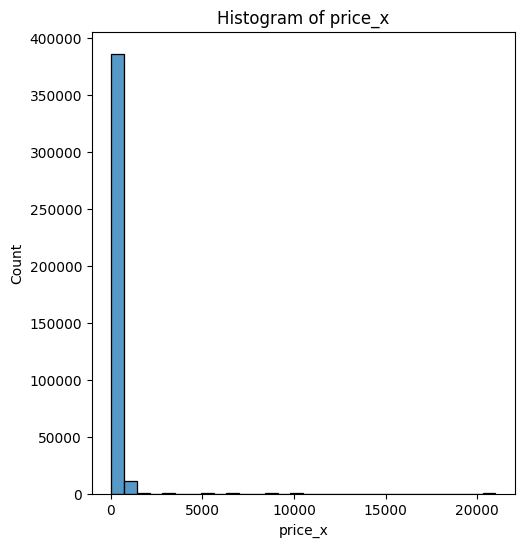

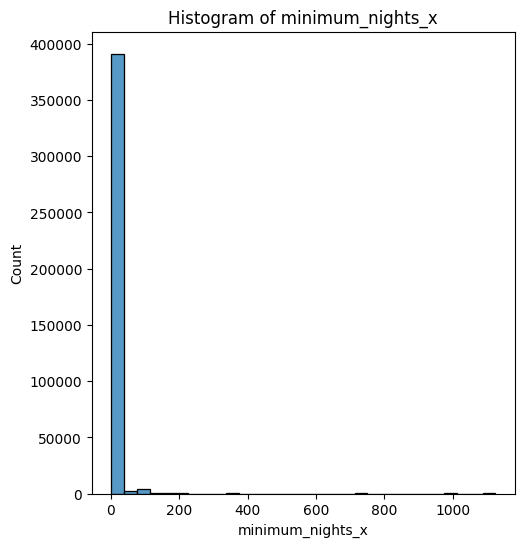

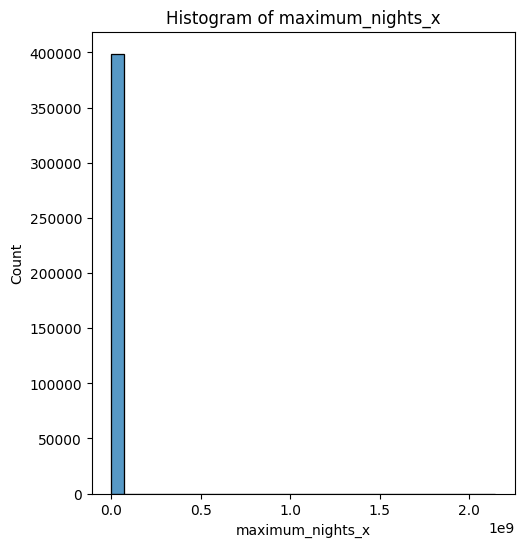

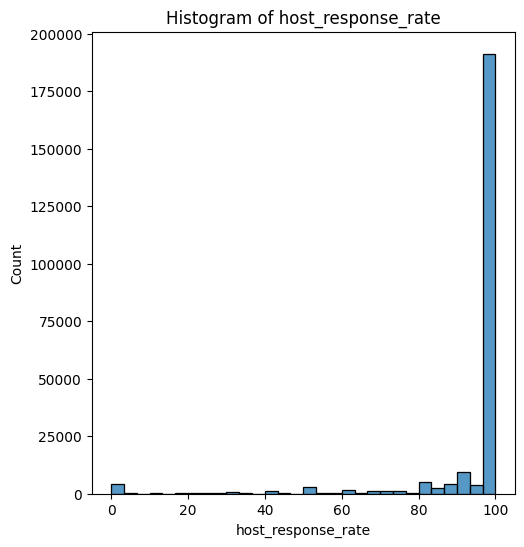

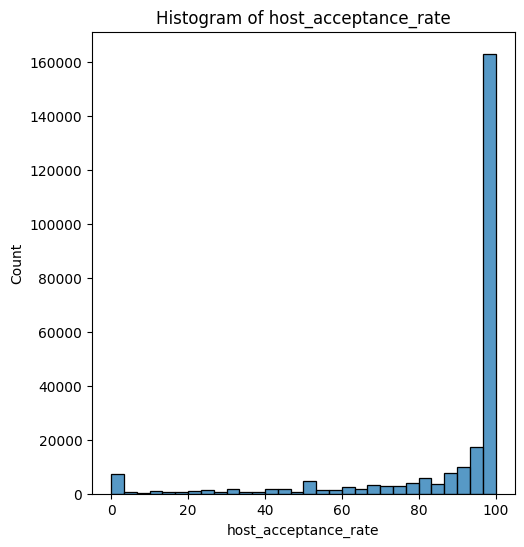

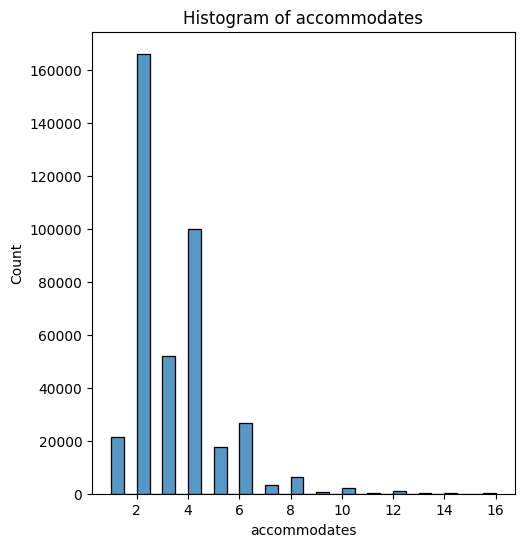

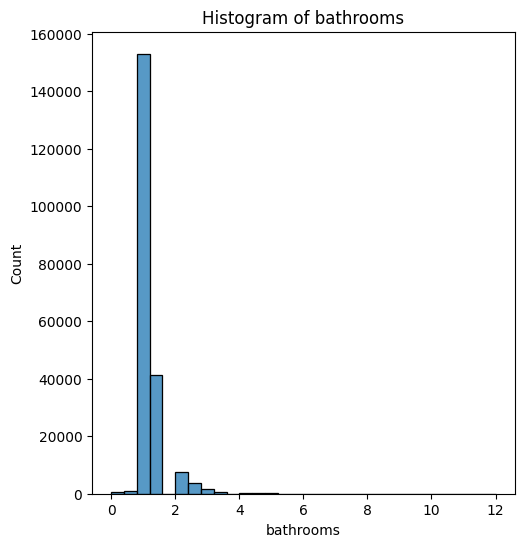

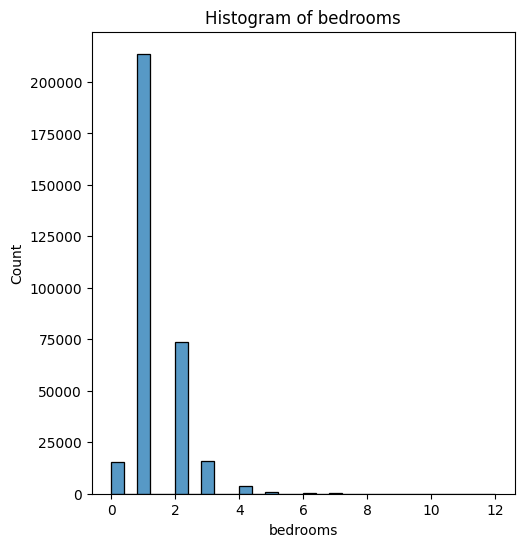

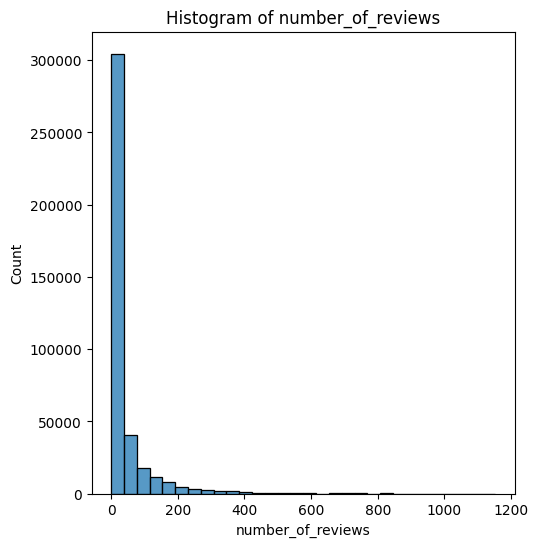

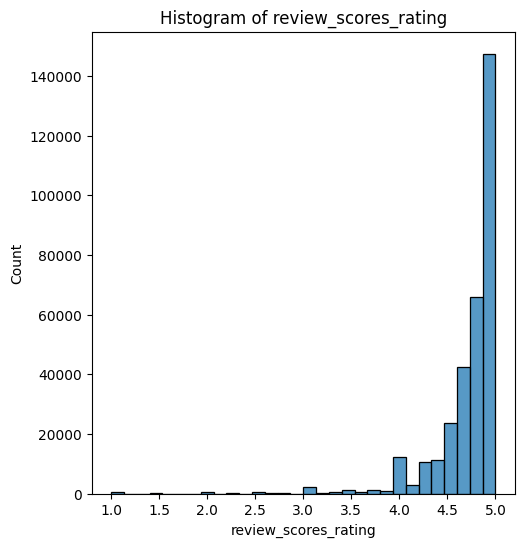

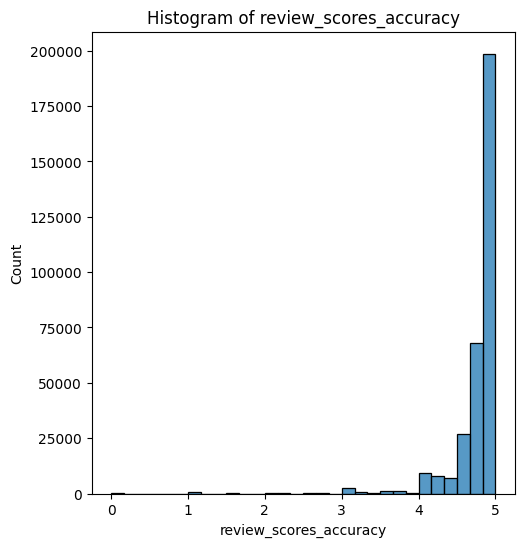

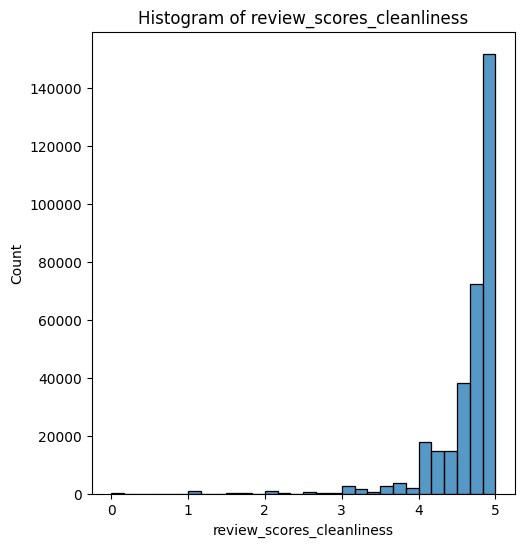

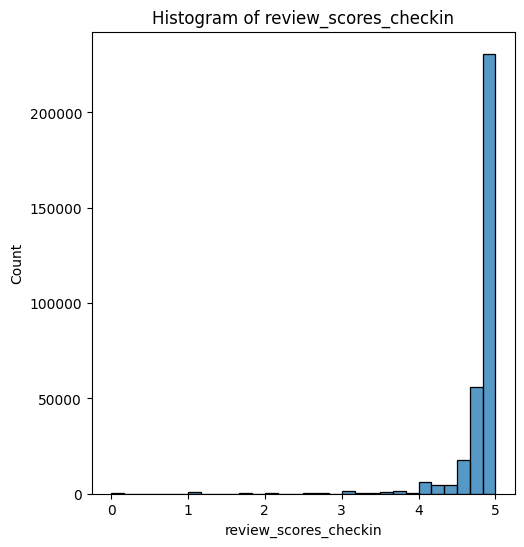

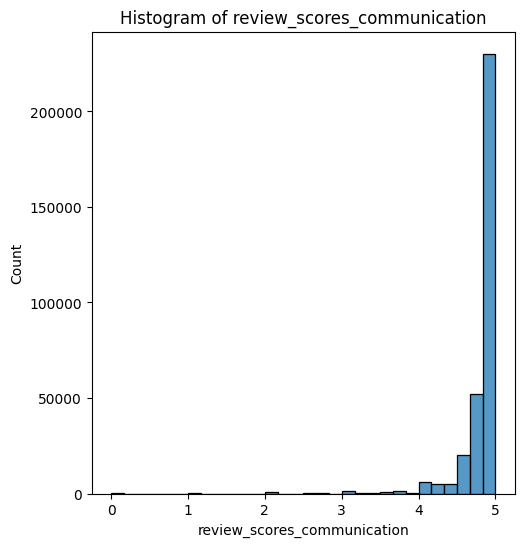

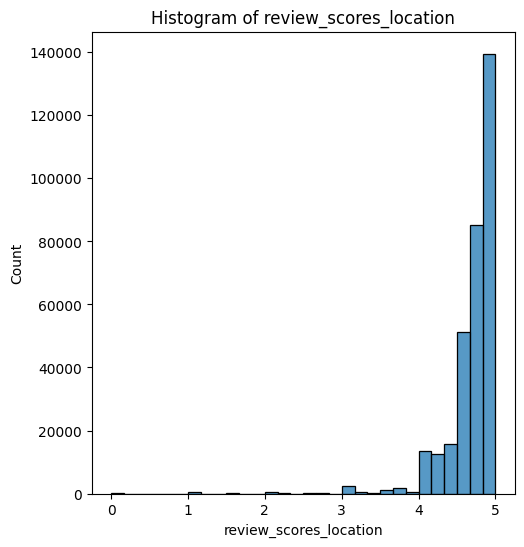

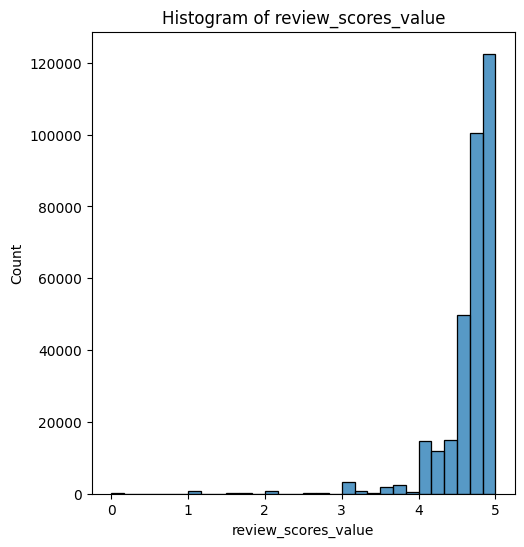

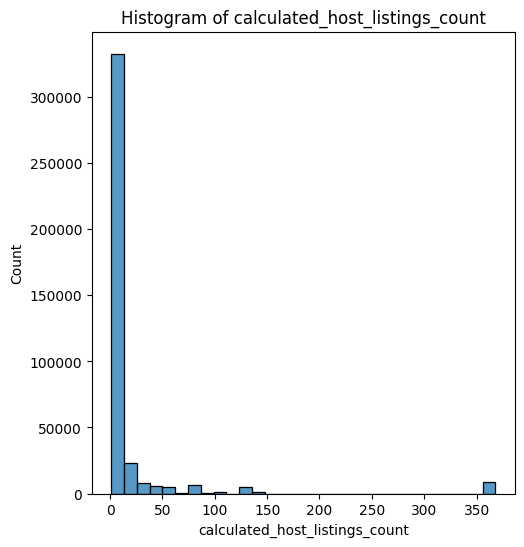

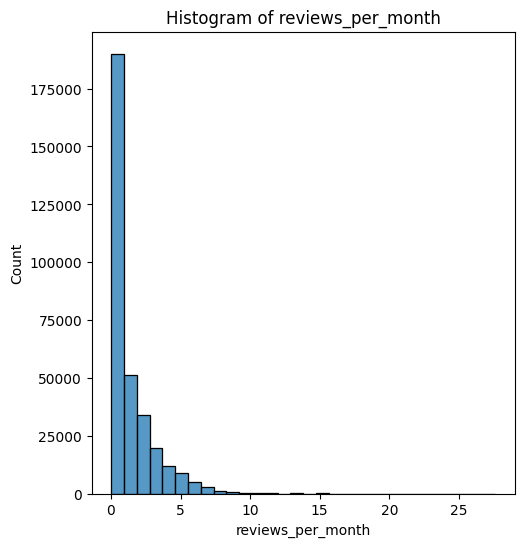

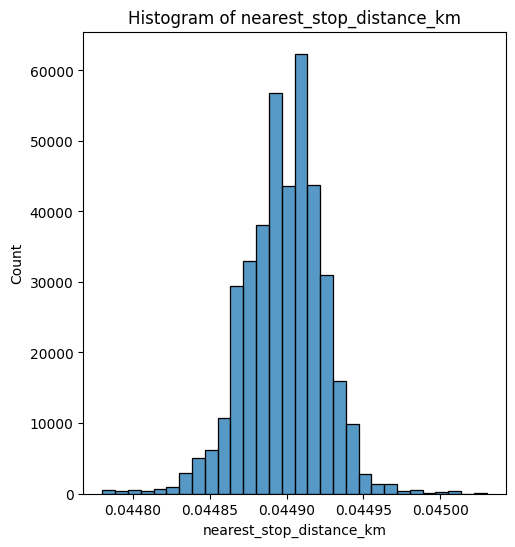

In [44]:
numeric_columns_excluding_id = [col for col in numeric_columns if col != 'listing_id']

for column in numeric_columns_excluding_id:
    plt.figure(figsize=(12, 6))

    # Histograms
    plt.subplot(1, 2, 1)
    sns.histplot(df[column], bins=30)
    plt.title(f'Histogram of {column}')

    plt.show()

In [ ]:
# correlation matrix

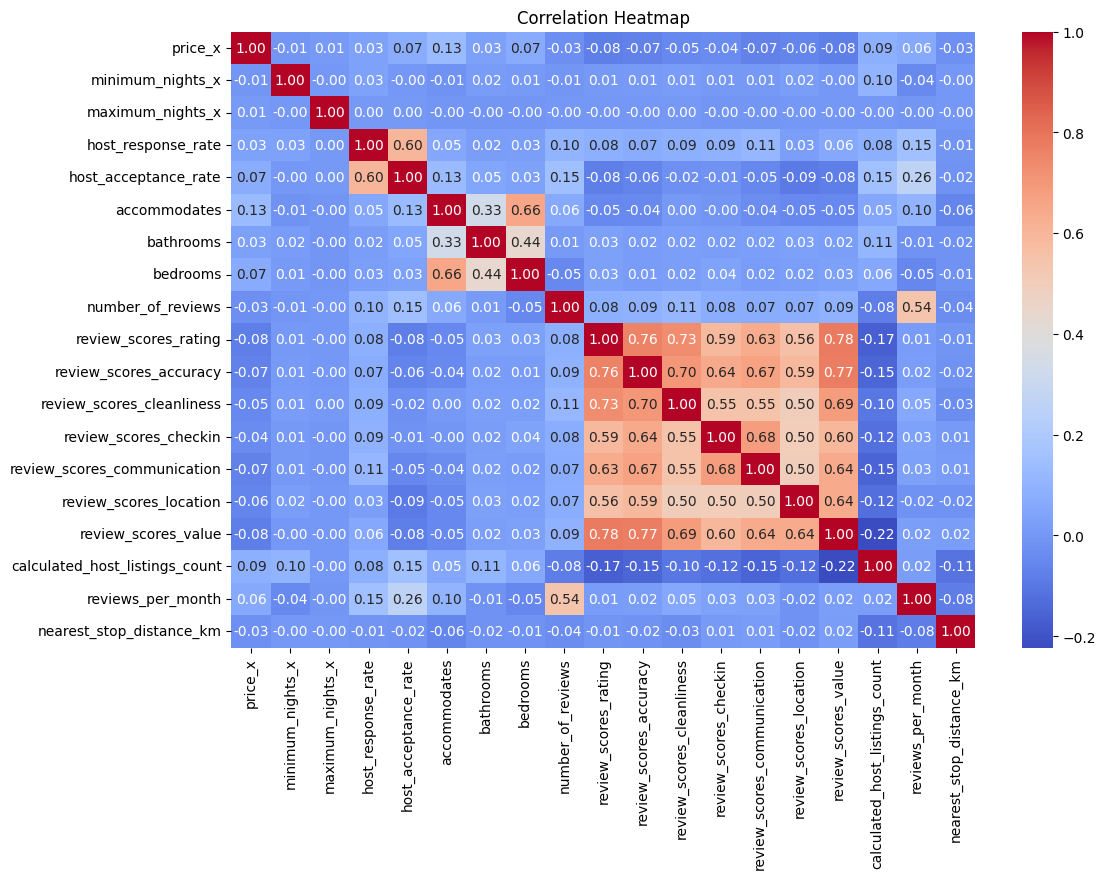

In [45]:
correlation_matrix = df[numeric_columns_excluding_id].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()


In [ ]:
# Analyze the relationship between pairs of features

# The relationship between price and the number of bedrooms
# The relationship between reviews and ratings
# The influence of the distance to the nearest stop on the price

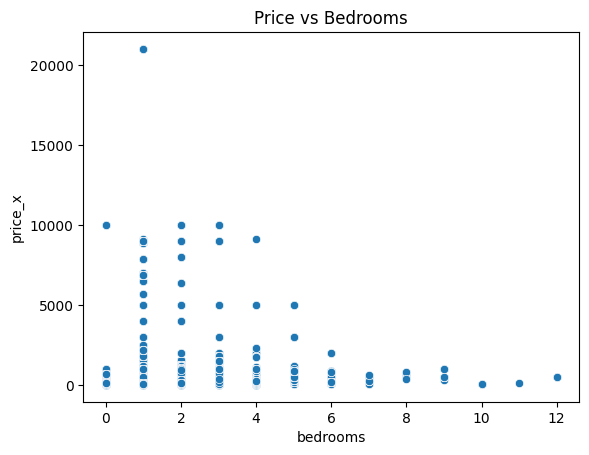

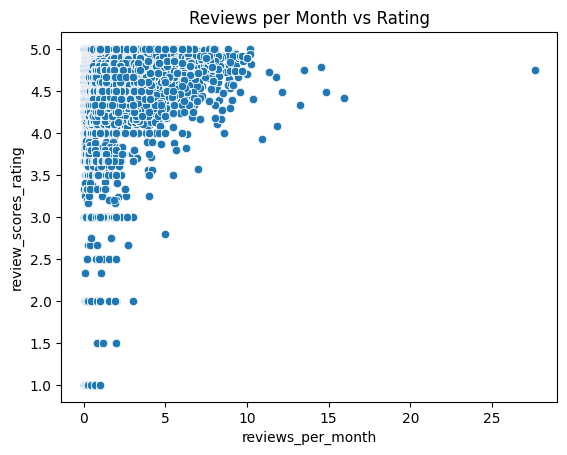

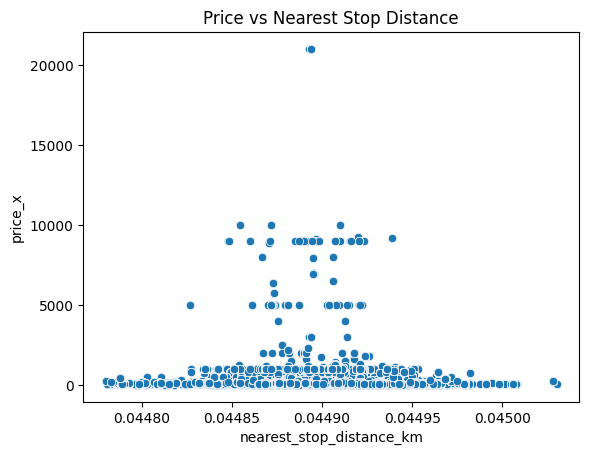

In [46]:
sns.scatterplot(data=df, x='bedrooms', y='price_x')
plt.title('Price vs Bedrooms')
plt.show()

sns.scatterplot(data=df, x='reviews_per_month', y='review_scores_rating')
plt.title('Reviews per Month vs Rating')
plt.show()

sns.scatterplot(data=df, x='nearest_stop_distance_km', y='price_x')
plt.title('Price vs Nearest Stop Distance')
plt.show()


In [ ]:
# Relationship between reviews and superhosts

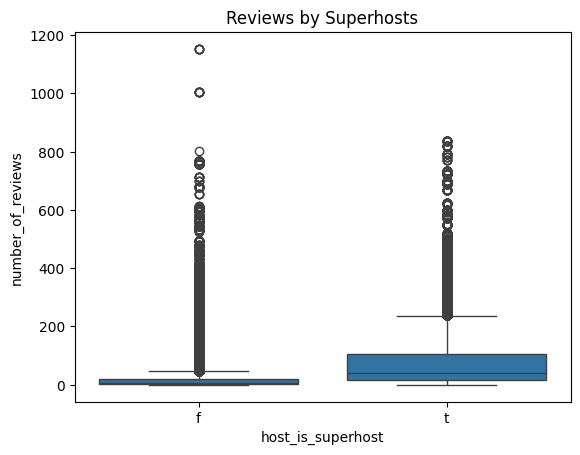

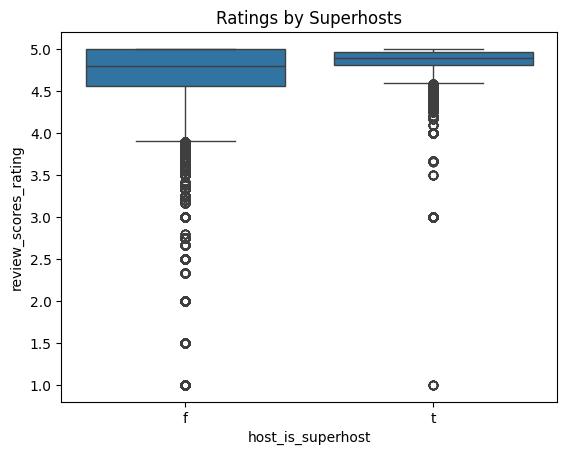

In [47]:
sns.boxplot(data=df, x='host_is_superhost', y='number_of_reviews')
plt.title('Reviews by Superhosts')
plt.show()

sns.boxplot(data=df, x='host_is_superhost', y='review_scores_rating')
plt.title('Ratings by Superhosts')
plt.show()


In [ ]:
# categorical columns

In [48]:
categorical_columns = df.select_dtypes(include=['object', 'category']).columns
print(categorical_columns)

Index(['host_response_time', 'host_is_superhost', 'host_has_profile_pic',
       'host_identity_verified', 'neighbourhood_cleansed', 'property_type',
       'amenities', 'nearest_pois'],
      dtype='object')


In [49]:
# all available values

for column in categorical_columns:
    print(f"Unique values in column {column}:")
    print(df[column].unique())
    print()


Unique values in column host_response_time:
['within an hour' nan 'within a few hours' 'within a day'
 'a few days or more']

Unique values in column host_is_superhost:
['f' 't' nan]

Unique values in column host_has_profile_pic:
['t' nan 'f']

Unique values in column host_identity_verified:
['t' 'f' nan]

Unique values in column neighbourhood_cleansed:
['Leopoldstadt', 'Rudolfsheim-Fnfhaus', 'Neubau', 'Ottakring', 'Hernals', ..., 'Donaustadt', 'Whring', 'Favoriten', 'Hietzing', 'Liesing']
Length: 23
Categories (23, object): ['Alsergrund', 'Brigittenau', 'Donaustadt', 'Dbling', ...,
                          'Rudolfsheim-Fnfhaus', 'Simmering', 'Wieden', 'Whring']

Unique values in column property_type:
['Entire rental unit', 'Private room in rental unit', 'Private room in condo', 'Entire condo', 'Entire serviced apartment', ..., 'Private room in barn', 'Barn', 'Castle', 'Shared room in bed and breakfast', 'Private room in dome']
Length: 54
Categories (54, object): ['Barn', 'Casa p

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 154 (\x9a) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 159 (\x9f) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 138 (\x8a) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


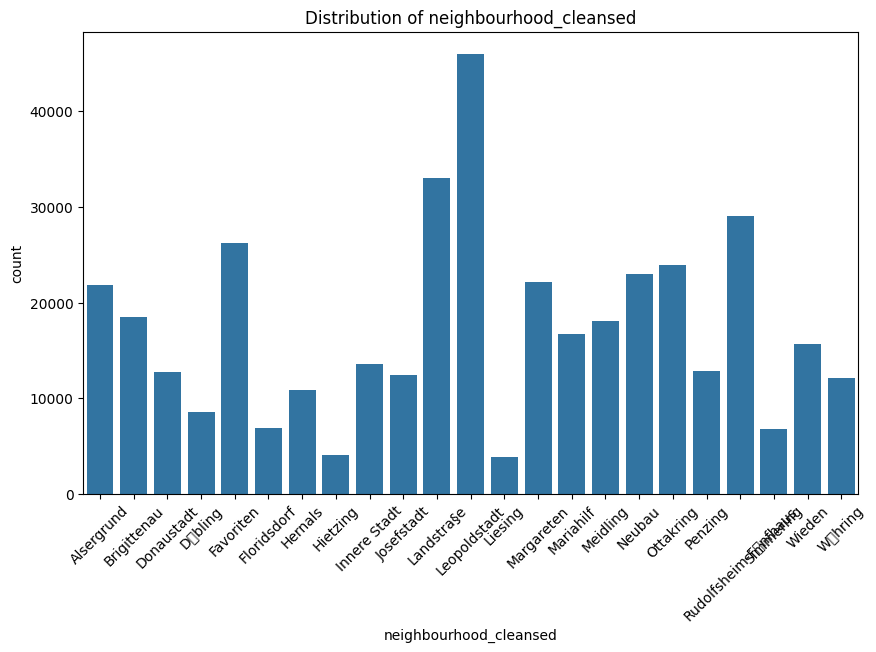

In [50]:
# distributin by districts

plt.figure(figsize=(10, 6))
sns.countplot(x='neighbourhood_cleansed', data=df)
plt.title(f'Distribution of {df["neighbourhood_cleansed"].name}')
plt.xticks(rotation=45)
plt.show()

## preprocessing

## split the datset into train, val, test

In [78]:
# Splitting data by features
from sklearn.model_selection import train_test_split

# Unique listing_id
listing_ids = df['listing_id'].unique()

# Splitting features into training, validation, and testing
train_ids, test_ids = train_test_split(listing_ids, test_size=0.3, random_state=42)
val_ids, test_ids = train_test_split(test_ids, test_size=0.5, random_state=42)

# Creating masks for samples
train_data = df[df['listing_id'].isin(train_ids)]
val_data = df[df['listing_id'].isin(val_ids)]
test_data = df[df['listing_id'].isin(test_ids)]

In [79]:
# target variable
y_train = train_data[['listing_id', 'price_x', 'start_date', 'end_date']]
y_val = val_data[['listing_id','price_x', 'start_date', 'end_date']]
y_test = test_data[['listing_id','price_x', 'start_date', 'end_date']]

train_data = train_data.drop(['price_x', 'start_date', 'end_date'], axis=1)
val_data = val_data.drop(['price_x', 'start_date', 'end_date'], axis=1)
test_data = test_data.drop(['price_x', 'start_date', 'end_date'], axis=1)

In [80]:
train_data.shape

(278598, 27)

In [81]:
y_train.shape

(278598, 4)

## preprocess numeric columns

In [82]:
numeric_columns = train_data.select_dtypes(include=['number']).columns
print(numeric_columns)

Index(['listing_id', 'minimum_nights_x', 'maximum_nights_x',
       'host_response_rate', 'host_acceptance_rate', 'accommodates',
       'bathrooms', 'bedrooms', 'number_of_reviews', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value',
       'calculated_host_listings_count', 'reviews_per_month',
       'nearest_stop_distance_km'],
      dtype='object')


In [83]:
# Check for missing values ​​for numeric columns
missing_values = train_data[numeric_columns].isnull().sum()
print(missing_values)

listing_id                             0
minimum_nights_x                       0
maximum_nights_x                       0
host_response_rate                115983
host_acceptance_rate              103335
accommodates                           0
bathrooms                         131666
bedrooms                           52825
number_of_reviews                      0
review_scores_rating               51410
review_scores_accuracy             51410
review_scores_cleanliness          51410
review_scores_checkin              51410
review_scores_communication        51410
review_scores_location             51410
review_scores_value                51437
calculated_host_listings_count         0
reviews_per_month                  51410
nearest_stop_distance_km               0
dtype: int64


In [84]:
# replace values in host_response_rate (if nan or < 100 -> 0, if 100 -> 1)

import numpy as np

def categorize_vectorized(values):
    categories = np.zeros(len(values), dtype=int)
    categories[values < 100] = 0
    categories[values == 100] = 1
    return categories

train_data.loc[:, 'host_response_rate'] = categorize_vectorized(train_data['host_response_rate'].fillna(-1).values)
val_data.loc[:, 'host_response_rate'] = categorize_vectorized(val_data['host_response_rate'].fillna(-1).values)
test_data.loc[:, 'host_response_rate'] = categorize_vectorized(test_data['host_response_rate'].fillna(-1).values)

In [85]:
# replace values in host_acceptance_rate (if nan or < 100 -> 0, if 100 -> 1)

train_data.loc[:, 'host_acceptance_rate'] = categorize_vectorized(train_data['host_acceptance_rate'].fillna(-1).values)
val_data.loc[:, 'host_acceptance_rate'] = categorize_vectorized(val_data['host_acceptance_rate'].fillna(-1).values)
test_data.loc[:, 'host_acceptance_rate'] = categorize_vectorized(test_data['host_acceptance_rate'].fillna(-1).values)

In [86]:
# If there is no bathroom data, replace missing values ​​with 0

train_data.loc[:,'bathrooms'] = train_data['bathrooms'].fillna(0)
val_data.loc[:,'bathrooms'] = val_data['bathrooms'].fillna(0)
test_data.loc[:,'bathrooms'] = test_data['bathrooms'].fillna(0)

In [87]:
# If there is no bedroom data, replace missing values ​​with 1

train_data.loc[:,'bedrooms'] = train_data['bedrooms'].fillna(1)
val_data.loc[:,'bedrooms'] = val_data['bedrooms'].fillna(1)
test_data.loc[:,'bedrooms'] = test_data['bedrooms'].fillna(1)

In [88]:
# If there is no review_score data, replace missing values ​​with 0

review_columns = ['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
                  'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
                  'review_scores_value', 'reviews_per_month']

for df in [train_data, val_data, test_data]:
    df.loc[:, review_columns] = df[review_columns].fillna(0)

In [ ]:
# check for outliers

In [89]:
# Calculate Q1, Q3 and IQR
Q1 = train_data[numeric_columns].quantile(0.25)
Q3 = train_data[numeric_columns].quantile(0.75)
IQR = Q3 - Q1

# Define ranges without outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# We leave only those lines that do not contain outliers
train_data = train_data[~((train_data[numeric_columns] < lower_bound) | (train_data[numeric_columns] > upper_bound)).any(axis=1)]


## preprocess categorical columns

In [90]:
categorical_columns = train_data.select_dtypes(include=['object', 'category']).columns
print(categorical_columns)

Index(['host_response_time', 'host_is_superhost', 'host_has_profile_pic',
       'host_identity_verified', 'neighbourhood_cleansed', 'property_type',
       'amenities', 'nearest_pois'],
      dtype='object')


In [91]:
# Check for missing values ​​for categorical columns
missing_values_cat = train_data[categorical_columns].isnull().sum()
print(missing_values_cat)

host_response_time        56708
host_is_superhost          1389
host_has_profile_pic          0
host_identity_verified        0
neighbourhood_cleansed        0
property_type                 0
amenities                     0
nearest_pois                  0
dtype: int64


In [92]:
missing_values_cat = train_data[categorical_columns].isnull().sum()
print(missing_values_cat)

host_response_time        56708
host_is_superhost          1389
host_has_profile_pic          0
host_identity_verified        0
neighbourhood_cleansed        0
property_type                 0
amenities                     0
nearest_pois                  0
dtype: int64


In [93]:
#  One-Hot Encoding
train_encoded = train_data['nearest_pois'].str.get_dummies(sep=', ')
val_encoded = val_data['nearest_pois'].str.get_dummies(sep=', ')
test_encoded = test_data['nearest_pois'].str.get_dummies(sep=', ')

# Append the encoded data back to the original DataFrame
train_data = pd.concat([train_data, train_encoded], axis=1)
val_data = pd.concat([val_data, val_encoded], axis=1)
test_data = pd.concat([test_data, test_encoded], axis=1)

In [94]:
# drop column 'nearest_pois' from DataFrame
train_data = train_data.drop(columns=['nearest_pois'])
val_data = val_data.drop(columns=['nearest_pois'])
test_data = test_data.drop(columns=['nearest_pois'])

In [95]:
# Applying One-Hot Encoding with .loc
train_data = pd.get_dummies(train_data, columns=['host_response_time'], drop_first=True)
val_data = pd.get_dummies(val_data, columns=['host_response_time'], drop_first=True)
test_data = pd.get_dummies(test_data, columns=['host_response_time'], drop_first=True)

In [96]:
# Replace NaN with 'f' using .loc
train_data.loc[:, 'host_is_superhost'] = train_data['host_is_superhost'].fillna('f')
val_data.loc[:, 'host_is_superhost'] = val_data['host_is_superhost'].fillna('f')
test_data.loc[:, 'host_is_superhost'] = test_data['host_is_superhost'].fillna('f')

# Apply One-Hot Encoding using get_dummies
train_data = pd.get_dummies(train_data, columns=['host_is_superhost'], drop_first=True)
val_data = pd.get_dummies(val_data, columns=['host_is_superhost'], drop_first=True)
test_data = pd.get_dummies(test_data, columns=['host_is_superhost'], drop_first=True)


In [97]:
# Apply One-Hot Encoding using get_dummies for both columns
train_data = pd.get_dummies(train_data, columns=['host_has_profile_pic'], drop_first=True)
val_data = pd.get_dummies(val_data, columns=['host_has_profile_pic'], drop_first=True)
test_data = pd.get_dummies(test_data, columns=['host_has_profile_pic'], drop_first=True)

train_data = pd.get_dummies(train_data, columns=['host_identity_verified'], drop_first=True)
val_data = pd.get_dummies(val_data, columns=['host_identity_verified'], drop_first=True)
test_data = pd.get_dummies(test_data, columns=['host_identity_verified'], drop_first=True)

In [98]:
train_data['neighbourhood_cleansed'] = train_data['neighbourhood_cleansed'].str.replace('Dbling', 'Dobling')
val_data['neighbourhood_cleansed'] = val_data['neighbourhood_cleansed'].str.replace('Dbling', 'Dobling')
test_data['neighbourhood_cleansed'] = test_data['neighbourhood_cleansed'].str.replace('Dbling', 'Dobling')

train_data['neighbourhood_cleansed'] = train_data['neighbourhood_cleansed'].str.replace('Whring', 'Wahring')
val_data['neighbourhood_cleansed'] = val_data['neighbourhood_cleansed'].str.replace('Whring', 'Wahring')
test_data['neighbourhood_cleansed'] = test_data['neighbourhood_cleansed'].str.replace('Whring', 'Wahring')

train_data['neighbourhood_cleansed'] = train_data['neighbourhood_cleansed'].str.replace('Rudolfsheim-Fnfhaus', 'Rudolfsheim-Funfhaus')
val_data['neighbourhood_cleansed'] = val_data['neighbourhood_cleansed'].str.replace('Rudolfsheim-Fnfhaus', 'Rudolfsheim-Funfhaus')
test_data['neighbourhood_cleansed'] = test_data['neighbourhood_cleansed'].str.replace('Rudolfsheim-Fnfhaus', 'Rudolfsheim-Funfhaus')


In [99]:
train_data = pd.get_dummies(train_data, columns=['neighbourhood_cleansed'], drop_first=True)
val_data = pd.get_dummies(val_data, columns=['neighbourhood_cleansed'], drop_first=True)
test_data = pd.get_dummies(test_data, columns=['neighbourhood_cleansed'], drop_first=True)

In [100]:
# Function to merge categories in property types
def reduce_property_type(property_type):
    if 'Entire' in property_type:
        return 'Entire'
    elif 'Private room' in property_type:
        return 'Private room'
    elif 'Shared room' in property_type:
        return 'Shared room'
    elif 'Room in' in property_type:
        return 'Room in hotel or similar'
    else:
        return 'Other'

# Apply the function with .loc
train_data.loc[:, 'property_type'] = train_data['property_type'].apply(reduce_property_type)
val_data.loc[:, 'property_type'] = val_data['property_type'].apply(reduce_property_type)
test_data.loc[:, 'property_type'] = test_data['property_type'].apply(reduce_property_type)

# Apply One-Hot Encoding with .loc
train_data = pd.get_dummies(train_data, columns=['property_type'], drop_first=True)
val_data = pd.get_dummies(val_data, columns=['property_type'], drop_first=True)
test_data = pd.get_dummies(test_data, columns=['property_type'], drop_first=True)

<ipython-input-100-38e4b5412a8f>:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['Entire' 'Entire' 'Entire' ... 'Private room' 'Private room'
 'Private room']' has dtype incompatible with category, please explicitly cast to a compatible dtype first.
  train_data.loc[:, 'property_type'] = train_data['property_type'].apply(reduce_property_type)
<ipython-input-100-38e4b5412a8f>:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['Entire' 'Entire' 'Entire' ... 'Private room' 'Private room'
 'Private room']' has dtype incompatible with category, please explicitly cast to a compatible dtype first.
  val_data.loc[:, 'property_type'] = val_data['property_type'].apply(reduce_property_type)
<ipython-input-100-38e4b5412a8f>:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['Private

In [101]:
#  One-Hot Encoding
train_encoded = train_data['amenities'].str.get_dummies(sep=', ')
val_encoded = val_data['amenities'].str.get_dummies(sep=', ')
test_encoded = test_data['amenities'].str.get_dummies(sep=', ')

# Append the encoded data back to the original DataFrame
train_data = pd.concat([train_data, train_encoded], axis=1)
val_data = pd.concat([val_data, val_encoded], axis=1)
test_data = pd.concat([test_data, test_encoded], axis=1)

In [102]:
# drop column 'amenities' from DataFrame
train_data = train_data.drop(columns=['amenities'])
val_data = val_data.drop(columns=['amenities'])
test_data = test_data.drop(columns=['amenities'])

In [103]:
train_data.columns

Index(['listing_id', 'minimum_nights_x', 'maximum_nights_x',
       'host_response_rate', 'host_acceptance_rate', 'accommodates',
       'bathrooms', 'bedrooms', 'number_of_reviews', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value',
       'calculated_host_listings_count', 'reviews_per_month',
       'nearest_stop_distance_km', 'cafe_restaurant', 'education',
       'entertainment_leisure', 'other', 'park', 'shops_and_retail',
       'supermarket', 'transport_and_infrastructure',
       'host_response_time_within a day',
       'host_response_time_within a few hours',
       'host_response_time_within an hour', 'host_is_superhost_t',
       'host_has_profile_pic_t', 'host_identity_verified_t',
       'neighbourhood_cleansed_Brigittenau', 'neighbourhood_cleansed_Dobling',
       'neighbourhood_cleansed_Donaustadt', 'neighbourhood_clea

In [104]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 99131 entries, 991 to 396322
Data columns (total 63 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   listing_id                                   99131 non-null  int64  
 1   minimum_nights_x                             99131 non-null  int64  
 2   maximum_nights_x                             99131 non-null  int64  
 3   host_response_rate                           99131 non-null  float64
 4   host_acceptance_rate                         99131 non-null  float64
 5   accommodates                                 99131 non-null  int64  
 6   bathrooms                                    99131 non-null  float64
 7   bedrooms                                     99131 non-null  float64
 8   number_of_reviews                            99131 non-null  int64  
 9   review_scores_rating                         99131 non-null  float64
 10  

In [105]:
# Check for missing values in the entire dataset
missing_values = train_data.isnull().sum()

# Print columns with missing values and their count
print(missing_values[missing_values > 0])

Series([], dtype: int64)


In [106]:
# Renaming columns
train_data.columns = train_data.columns.str.replace('host_is_superhost_t', 'is_superhost')
train_data.columns = train_data.columns.str.replace('host_has_profile_pic_t', 'host_has_profile_pic')
train_data.columns = train_data.columns.str.replace('host_identity_verified_t', 'host_identity_verified')
train_data.columns = train_data.columns.str.replace('neighbourhood_cleansed_', 'neighbourhood_')
train_data.columns = train_data.columns.str.replace('property_type_', 'property_type_')

val_data.columns = val_data.columns.str.replace('host_is_superhost_t', 'is_superhost')
val_data.columns = val_data.columns.str.replace('host_has_profile_pic_t', 'host_has_profile_pic')
val_data.columns = val_data.columns.str.replace('host_identity_verified_t', 'host_identity_verified')
val_data.columns = val_data.columns.str.replace('neighbourhood_cleansed_', 'neighbourhood_')
val_data.columns = val_data.columns.str.replace('property_type_', 'property_type_')

test_data.columns = test_data.columns.str.replace('host_is_superhost_t', 'is_superhost')
test_data.columns = test_data.columns.str.replace('host_has_profile_pic_t', 'host_has_profile_pic')
test_data.columns = test_data.columns.str.replace('host_identity_verified_t', 'host_identity_verified')
test_data.columns = test_data.columns.str.replace('neighbourhood_cleansed_', 'neighbourhood_')
test_data.columns = test_data.columns.str.replace('property_type_', 'property_type_')

train_data.columns = train_data.columns.str.replace('price_x', 'price')
train_data.columns = train_data.columns.str.replace('minimum_nights_x', 'min_nights')
train_data.columns = train_data.columns.str.replace('maximum_nights_x', 'max_nights')
train_data.columns = train_data.columns.str.replace('host_response_rate', 'host_response_rate')
train_data.columns = train_data.columns.str.replace('host_acceptance_rate', 'host_acceptance_rate')
train_data.columns = train_data.columns.str.replace('calculated_host_listings_count', 'host_has_listings')

val_data.columns = val_data.columns.str.replace('price_x', 'price')
val_data.columns = val_data.columns.str.replace('minimum_nights_x', 'min_nights')
val_data.columns = val_data.columns.str.replace('maximum_nights_x', 'max_nights')
val_data.columns = val_data.columns.str.replace('host_response_rate', 'host_response_rate')
val_data.columns = val_data.columns.str.replace('host_acceptance_rate', 'host_acceptance_rate')
val_data.columns = val_data.columns.str.replace('calculated_host_listings_count', 'host_has_listings')

test_data.columns = test_data.columns.str.replace('price_x', 'price')
test_data.columns = test_data.columns.str.replace('minimum_nights_x', 'min_nights')
test_data.columns = test_data.columns.str.replace('maximum_nights_x', 'max_nights')
test_data.columns = test_data.columns.str.replace('host_response_rate', 'host_response_rate')
test_data.columns = test_data.columns.str.replace('host_acceptance_rate', 'host_acceptance_rate')
test_data.columns = test_data.columns.str.replace('calculated_host_listings_count', 'host_has_listings')


train_data.columns = train_data.columns.str.replace(' ', '_')
val_data.columns = val_data.columns.str.replace(' ', '_')
test_data.columns = test_data.columns.str.replace(' ', '_')

print(train_data.columns)

Index(['listing_id', 'min_nights', 'max_nights', 'host_response_rate',
       'host_acceptance_rate', 'accommodates', 'bathrooms', 'bedrooms',
       'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'host_has_listings', 'reviews_per_month',
       'nearest_stop_distance_km', 'cafe_restaurant', 'education',
       'entertainment_leisure', 'other', 'park', 'shops_and_retail',
       'supermarket', 'transport_and_infrastructure',
       'host_response_time_within_a_day',
       'host_response_time_within_a_few_hours',
       'host_response_time_within_an_hour', 'is_superhost',
       'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood_Brigittenau', 'neighbourhood_Dobling',
       'neighbourhood_Donaustadt', 'neighbourhood_Favoriten',
       'neighbourhood_Floridsdorf', 'neighbourhood_Hernals',
 

In [107]:
# Save the datasets to CSV files
train_data.to_csv('train_data_processed.csv', index=False)
val_data.to_csv('val_data_processed.csv', index=False)
test_data.to_csv('test_data_processed.csv', index=False)

y_train.to_csv('y_train_processed.csv', index=False)
y_val.to_csv('y_val_processed.csv', index=False)